In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import lalsimulation as lalsim

from pycbc.filter.matchedfilter import match
from pycbc.types import FrequencySeries

from bilby_lisa.source import lisa_binary_black_hole
from bilby_lisa.source_LW import lisa_LW_gwsignal_binary_black_hole, lisa_LW_gwsignal_binary_black_hole_pSEOB
from lisatools.sensitivity import get_sensitivity

import seaborn as sns

sns.set_theme(
    context="notebook",
    style="whitegrid",
    palette="deep",
    font_scale=1.5,
)

/home/lpompili/.conda/envs/pSEOB311/lib/python3.11/site-packages/lalsimulation/lalsimulation.py:8: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal


In [3]:
Mtot = 2e7
q = 2
m1 = q / (1 + q) * Mtot
m2 = 1 / (1 + q) * Mtot
s1x = 0.0
s1y = 0.0
s1z = 0.9
s2x = 0.0
s2y = 0.0
s2z = 0.9
phiRef = 0.0
distance = 25 * 1e3
inclination = np.pi / 3

f_max = 1e-2
f_ref = 1e-4
f_min = 1e-4
deltaF = 1e-7
frequency_array = np.arange(f_min, f_max, deltaF)

ra = np.pi / 3
dec = np.pi / 3
psi = np.pi / 3

geocent_time = 0.0

In [4]:
dict_bbhx = lisa_binary_black_hole(
    frequency_array, m1, m2, distance, s1z, s2z,
    inclination, phiRef, ra, dec, psi, geocent_time,
    reference_frequency=f_ref, minimum_frequency=f_min
)

No CuPy
No CuPy or GPU PhenomHM module.
No CuPy or GPU response available.
No CuPy or GPU interpolation available.


In [5]:
(theta_jn, phi_jl, tilt_1, tilt_2, phi_12, a_1, a_2) = (
    lalsim.SimInspiralTransformPrecessingWvf2PE(
        inclination, s1x, s1y, s1z, s2x, s2y, s2z, m1, m2, f_ref, phiRef
    )
)

In [6]:
dict_lw = lisa_LW_gwsignal_binary_black_hole(frequency_array, m1, m2, distance, 
                                       a_1, tilt_1, phi_12, a_2, tilt_2, phi_jl, theta_jn, phiRef, 
                                       ra, dec, psi, geocent_time, waveform_approximant = "IMRPhenomD", 
                                       reference_frequency=f_ref, minimum_frequency=f_min,
                                       # mode_array=[(2,2)]
                                       )

/home/lpompili/.conda/envs/pSEOB311/lib/python3.11/site-packages/lalsimulation/gwsignal/core/waveform.py:226: UserWarning: This code is currently UNREVIEWED, use with caution!
  warnings.warn("This code is currently UNREVIEWED, use with caution!")


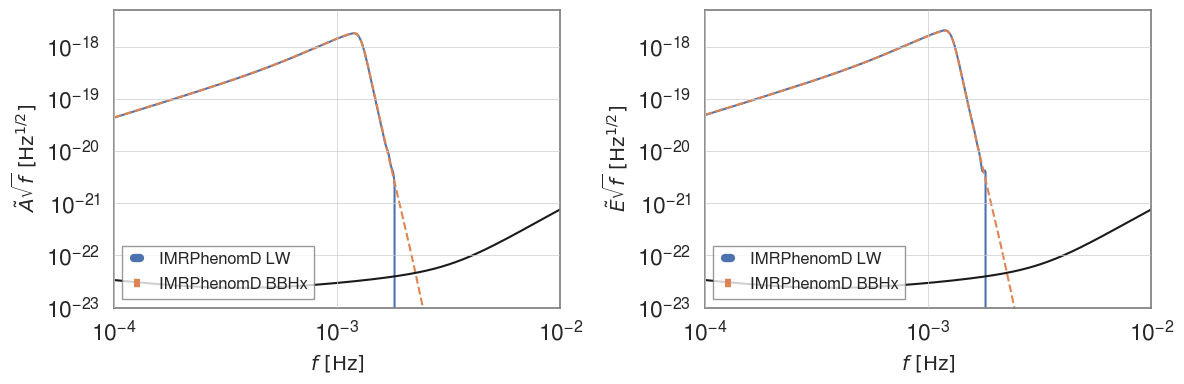

In [7]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (12,4))

ax1.loglog(frequency_array, np.sqrt(frequency_array) * np.abs(dict_lw["LISA_A"]), label = "IMRPhenomD LW")
ax1.loglog(frequency_array, np.sqrt(frequency_array) * np.abs(dict_bbhx["LISA_A"]), label = "IMRPhenomD BBHx", ls = '--')

ax2.loglog(frequency_array, np.sqrt(frequency_array) * np.abs(dict_lw["LISA_E"]), label = "IMRPhenomD LW")
ax2.loglog(frequency_array, np.sqrt(frequency_array) * np.abs(dict_bbhx["LISA_E"]), label = "IMRPhenomD BBHx", ls = '--')

fn = np.logspace(-5, -1, 10000)

Sn_char_strain = get_sensitivity(fn, sens_fn="A1TDISens", return_type="char_strain")
ax1.loglog(fn, Sn_char_strain, c="k")

Sn_char_strain = get_sensitivity(fn, sens_fn="E1TDISens", return_type="char_strain")
ax2.loglog(fn, Sn_char_strain, c="k")

for ax in (ax1,ax2):
    ax.set_xlim(f_min, f_max)
    ax.set_ylim(1e-23, 5e-18)
    ax.set_xlabel(r"$f~[\rm{Hz}]$")
    ax.legend(loc=3, fontsize=12)

ax1.set_ylabel(r"$\tilde{A}\sqrt{f}~[\rm{Hz}^{1/2}]$")
ax2.set_ylabel(r"$\tilde{E}\sqrt{f}~[\rm{Hz}^{1/2}]$")

plt.tight_layout()


In [8]:
psd = get_sensitivity(frequency_array, sens_fn="A1TDISens", return_type="PSD")
print(
    1- match(
        FrequencySeries(dict_bbhx["LISA_A"], deltaF),
        FrequencySeries(dict_lw["LISA_A"], deltaF),
        psd=FrequencySeries(psd, deltaF),
    )[0]
)

0.0001540052382186241


In [9]:
dict_seob = lisa_LW_gwsignal_binary_black_hole(frequency_array, m1, m2, distance, 
                                       a_1, tilt_1, phi_12, a_2, tilt_2, phi_jl, theta_jn, phiRef, 
                                       ra, dec, psi, geocent_time, waveform_approximant = "SEOBNRv5PHM", 
                                       reference_frequency=f_ref, minimum_frequency=f_min,
                                       # mode_array=[(2,2)]
                                       )

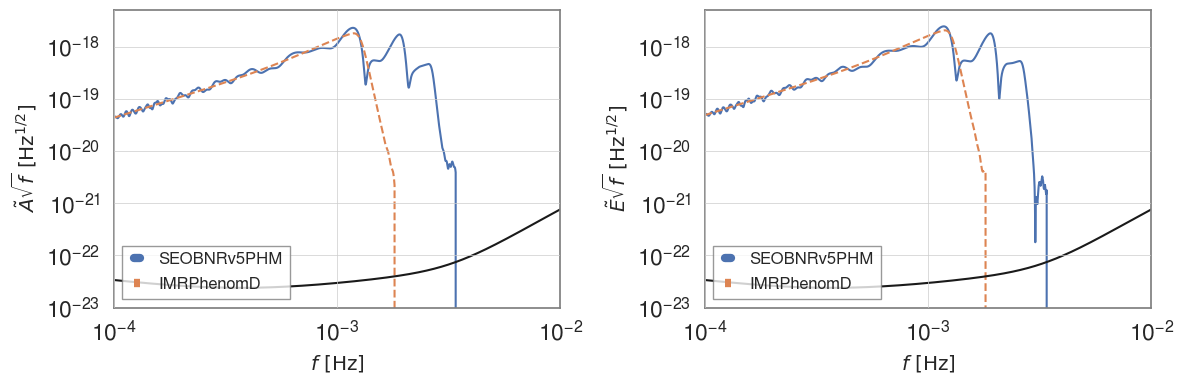

In [10]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (12,4))

ax1.loglog(frequency_array, np.sqrt(frequency_array) * np.abs(dict_seob["LISA_A"]), label = "SEOBNRv5PHM")
ax1.loglog(frequency_array, np.sqrt(frequency_array) * np.abs(dict_lw["LISA_A"]), label = "IMRPhenomD", ls = '--')

ax2.loglog(frequency_array, np.sqrt(frequency_array) * np.abs(dict_seob["LISA_E"]), label = "SEOBNRv5PHM")
ax2.loglog(frequency_array, np.sqrt(frequency_array) * np.abs(dict_lw["LISA_E"]), label = "IMRPhenomD", ls = '--')

fn = np.logspace(-5, -1, 10000)

Sn_char_strain = get_sensitivity(fn, sens_fn="A1TDISens", return_type="char_strain")
ax1.loglog(fn, Sn_char_strain, c="k")

Sn_char_strain = get_sensitivity(fn, sens_fn="E1TDISens", return_type="char_strain")
ax2.loglog(fn, Sn_char_strain, c="k")

for ax in (ax1,ax2):
    ax.set_xlim(f_min, f_max)
    ax.set_ylim(1e-23, 5e-18)
    ax.set_xlabel(r"$f~[\rm{Hz}]$")
    ax.legend(loc=3, fontsize=12)

ax1.set_ylabel(r"$\tilde{A}\sqrt{f}~[\rm{Hz}^{1/2}]$")
ax2.set_ylabel(r"$\tilde{E}\sqrt{f}~[\rm{Hz}^{1/2}]$")

plt.tight_layout()


In [11]:
domega220 = 0.5
dtau220 = 0.0

domega330 = 0
dtau330 = 0
domega210 = 0
dtau210 = 0
domega440 = 0
dtau440 = 0
domega550 = 0
dtau550 = 0
domega320 = 0
dtau320 = 0
domega430 = 0
dtau430 = 0
dA22 = 0
dw22 = 0
dA33 = 0
dw33 = 0
dA21 = 0
dw21 = 0
dA44 = 0
dw44 = 0
dA55 = 0
dw55 = 0
dA32 = 0
dw32 = 0
dA43 = 0
dw43 = 0
dTpeak = 0
da6 = 0
ddSO = 0

In [12]:
dict_pseob = lisa_LW_gwsignal_binary_black_hole_pSEOB(frequency_array, m1, m2, distance, 
                                       a_1, tilt_1, phi_12, a_2, tilt_2, phi_jl, theta_jn, phiRef, 
                                       ra, dec, psi, geocent_time, 
                                       domega220, dtau220, domega330, dtau330, domega210, dtau210, 
                                       domega440, dtau440, domega550, dtau550, domega320, dtau320, 
                                       domega430, dtau430, dA22, dw22, dA33, dw33, dA21, dw21, dA44, 
                                       dw44, dA55, dw55, dA32, dw32, dA43, dw43, dTpeak, da6, ddSO,
                                       waveform_approximant = "SEOBNRv5PHM", 
                                       reference_frequency=f_ref, minimum_frequency=f_min,
                                       # mode_array=[(2,2)]
                                       )

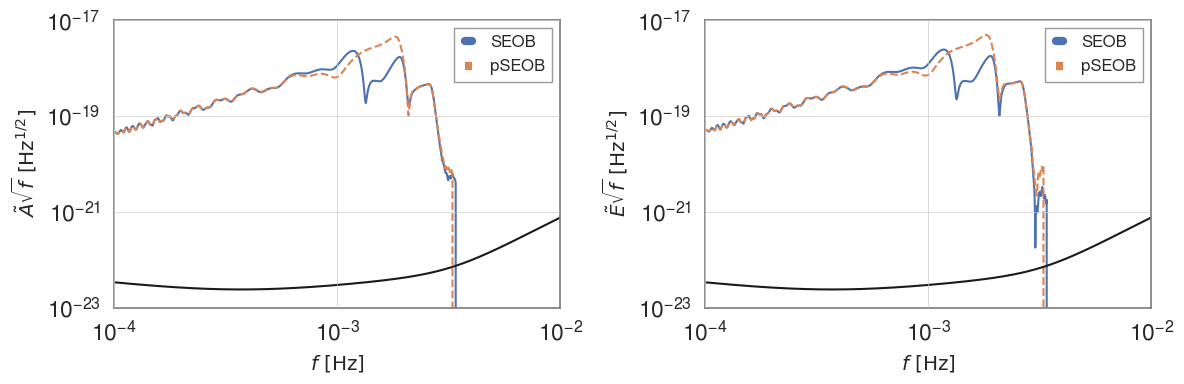

In [14]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (12,4))

ax1.loglog(frequency_array, np.sqrt(frequency_array) * np.abs(dict_seob["LISA_A"]), label = "SEOB")
ax1.loglog(frequency_array, np.sqrt(frequency_array) * np.abs(dict_pseob["LISA_A"]), label = "pSEOB", ls = '--')

ax2.loglog(frequency_array, np.sqrt(frequency_array) * np.abs(dict_seob["LISA_E"]), label = "SEOB")
ax2.loglog(frequency_array, np.sqrt(frequency_array) * np.abs(dict_pseob["LISA_E"]), label = "pSEOB", ls = '--')

fn = np.logspace(-5, -1, 10000)

Sn_char_strain = get_sensitivity(fn, sens_fn="A1TDISens", return_type="char_strain")
ax1.loglog(fn, Sn_char_strain, c="k")

Sn_char_strain = get_sensitivity(fn, sens_fn="E1TDISens", return_type="char_strain")
ax2.loglog(fn, Sn_char_strain, c="k")

for ax in (ax1,ax2):
    ax.set_xlim(f_min, f_max)
    ax.set_ylim(1e-23, 1e-17)
    ax.set_xlabel(r"$f~[\rm{Hz}]$")
    ax.legend(loc=1, fontsize=12)

ax1.set_ylabel(r"$\tilde{A}\sqrt{f}~[\rm{Hz}^{1/2}]$")
ax2.set_ylabel(r"$\tilde{E}\sqrt{f}~[\rm{Hz}^{1/2}]$")

plt.tight_layout()
